In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import eigsh

In [ ]:
def solve_quantum_billiards(N=100, shape='circle', num_levels=5):
    
    # Define the Grid, we approximate this continuous space as a lattice of points.
    L = 2.0
    x = np.linspace(-L/2, L/2, N)
    y = np.linspace(-L/2, L/2, N)
    X, Y = np.meshgrid(x, y) # creating the grid
    dx = x[1] - x[0] #step size
    
    #the potential V(x,y)=0 if the condition is true, and V(x,y)=infinity if false.
    if shape == 'circle':
        radius = 0.8
        mask = (X**2 + Y**2) < radius**2
        
    elif shape == 'square':
        mask = (np.abs(X) < 0.7) & (np.abs(Y) < 0.7)
    
    elif shape == 'stadium':
        # Classic Bunimovich stadium (two semicircles + rectangle)
        rect_width = 1.0
        radius = 0.5
        
        in_rect = (np.abs(X) < rect_width/2) & (np.abs(Y) < radius)
        in_circ_left = ((X + rect_width/2)**2 + Y**2) < radius**2
        in_circ_right = ((X - rect_width/2)**2 + Y**2) < radius**2
        mask = in_rect | in_circ_left | in_circ_right
        
    else:
        raise ValueError("Unknown shape")
    
    #We approximate the second derivative using the Central Finite Difference formula
    diag_main = -2 * np.ones(N)
    diag_off = np.ones(N-1)
    D = sparse.diags([diag_off, diag_main, diag_off], [-1, 0, 1], shape=(N, N))
    D = D / (dx**2)
    
    Laplacian = sparse.kronsum(D, D)
    T = -0.5 * Laplacian
    mask_flat = mask.flatten()
    
    V_large = 1e10 # infinity
    potential_diag = np.zeros(N**2)
    potential_diag[~mask_flat] = V_large
    V = sparse.diags(potential_diag)
    
    H = T + V
    
    # 6. Solve for Eigenvalues
    # 'SM' = Smallest Magnitude (Lowest energy states)
    eigenvalues, eigenvectors = eigsh(H, k=num_levels, which='SM')
    
    return eigenvalues, eigenvectors, X, Y, mask



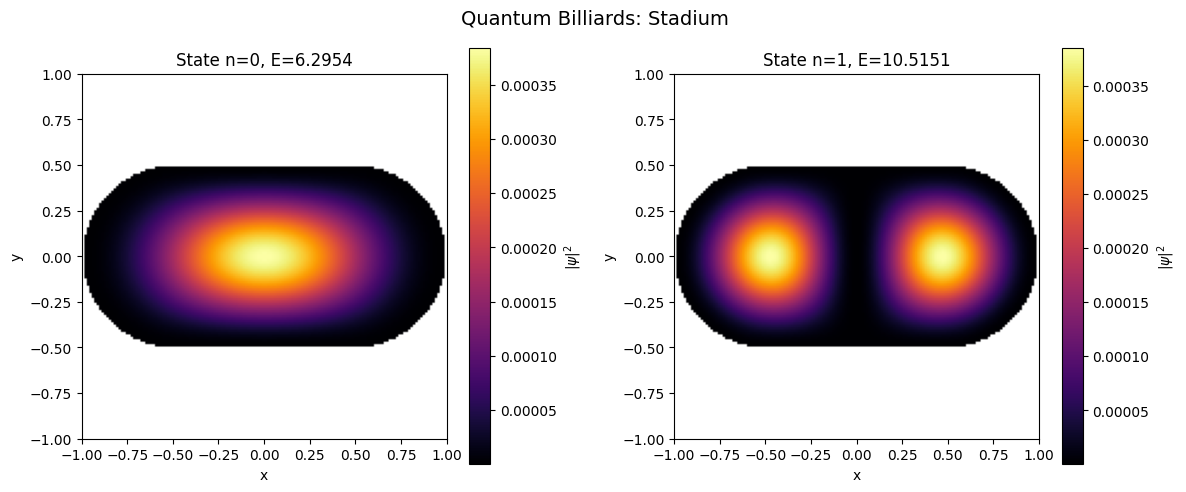

In [6]:
N = 150
shape_type = 'stadium' # Try 'circle', 'square', 'stadium'
vals, vecs, X, Y, mask = solve_quantum_billiards(N, shape_type)

# Plotting the Ground State (n=0) and First Excited State (n=1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

states_to_plot = [0, 1] # Indices of states to plot

for i, state_idx in enumerate(states_to_plot):
    
    psi = vecs[:, state_idx].reshape((N, N))
    
    prob_density = np.abs(psi)**2
    
    ax = axes[i]
    prob_density[~mask] = np.nan 
    
    im = ax.imshow(prob_density, extent=[-1, 1, -1, 1], origin='lower', cmap='inferno')
    ax.set_title(f"State n={state_idx}, E={vals[state_idx]:.4f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax, label='$|\psi|^2$')

plt.suptitle(f"Quantum Billiards: {shape_type.capitalize()}", fontsize=14)
plt.tight_layout()
plt.show()